In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nb
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import cv2
from scipy import ndimage
from scipy.stats import gaussian_kde

import matplotlib.patches as patches

In [2]:
"""
The new and improved linear regression. From now on, we're focusing on doing things very visually and always plotting MRI v. SoS. 
Then we can do the linear regression and see how it lines up with the points (pun intended).
We mainly use class Section to make things as simple as possible. This class has certain variables.

Variables guide:
 . label : list used to create region from whole MRI slice. aka. where is this section?
       [0] slice number
       [1] start y value
       [2] end y value
       [3] start x value
       [4] end x value
 . m : MRI of section
 . s : SoS image of section
 . fil_m : filtered MRI, without skull and CSF
 . fil_s : filtered SoS image, without skull and CSF
 . m_m : median filtered MRI
 . m_s : median filtered SoS image
 . fil_m_m : median filtered, tissue filtered MRI (median filtered without skull or CSF)
 . fil_m_s : median filtered, tissue filtered SoS Image (median filtered without skull or CSF)
 . coef : coefficient of linear regression (gradient of line) between MRI and SoS points
 . intercept : SoS-intercept of linear regression between MRI and SoS points
 . r2 : R^2 value of linear regression
 . f_df : tissue filtered dataframe of MRI
 . df : dataframe of MRI without outliers
"""


"\nThe new and improved linear regression. From now on, we're focusing on doing things very visually and always plotting MRI v. SoS. \nThen we can do the linear regression and see how it lines up with the points (pun intended).\nWe mainly use class Section to make things as simple as possible. This class has certain variables.\n\nVariables guide:\n . label : list used to create region from whole MRI slice. aka. where is this section?\n       [0] slice number\n       [1] start y value\n       [2] end y value\n       [3] start x value\n       [4] end x value\n . m : MRI of section\n . s : SoS image of section\n . fil_m : filtered MRI, without skull and CSF\n . fil_s : filtered SoS image, without skull and CSF\n . m_m : median filtered MRI\n . m_s : median filtered SoS image\n . fil_m_m : median filtered, tissue filtered MRI (median filtered without skull or CSF)\n . fil_m_s : median filtered, tissue filtered SoS Image (median filtered without skull or CSF)\n . coef : coefficient of linea

In [3]:
mri_file = glob('/Volumes/DISK_IMG/100610/m100610_T1w.nii.gz')[0]
mri_im = nb.load(mri_file)
mri_data = mri_im.get_fdata()

sos_file = glob('/Volumes/DISK_IMG/100610/Vp.nii.gz')[0]
sos_im = nb.load(sos_file)
sos_data = sos_im.get_fdata()

In [4]:
class Section:
    def __init__(self, m, s, label):
        self.m = m
        self.s = s
        self.label = label

    def apply_filter(self, median, T):
        """
        Filters MRI and SoS Image by tissue (removes skull and CSF)
         . bool median : True if MRI and SoS being filtered have been median-filtered
         . [T[0], T[1]] : minimum and maximum SoS values to keep

        Returns: 
         . fil_m : filtered MRI, without skull and CSF
         . fil_s : filtered SoS image, without skull and CSF
        """
        fil_m = []
        fil_s = []
        if(median):
            temp_m = np.array(self.m_m).flatten()
            temp_s = np.array(self.m_s).flatten()
        else:
            temp_m = np.array(self.m).flatten()
            temp_s = np.array(self.s).flatten()

        for x in range(temp_s.shape[0]):
            if(not np.isnan(T[0])) and (np.isnan(T[1])): #only filtering downwards
                # print("filtering downwards")
                if(temp_s[x] > T[0]):
                    fil_m.append(temp_m[x])
                    fil_s.append(temp_s[x])

            if( np.isnan(T[0]) ) and (not np.isnan(T[1])): #only filtering upwards
                # print("filtering upwards")
                if(temp_s[x] < T[1]):
                    fil_m.append(temp_m[x])
                    fil_s.append(temp_s[x])
                # else: print(temp_s[x])
            
            if(not np.isnan(T[0])) and (not np.isnan(T[1])): #filtering in both directions
                # print("filtering both")
                if(temp_s[x] > T[0]) and (temp_s[x] < T[1]):
                    fil_m.append(temp_m[x])
                    fil_s.append(temp_s[x])

        return fil_m, fil_s

    def filter(self, T):
        """
        Filter non-median-filtered images
        """
        self.fil_m, self.fil_s = self.apply_filter(False, T)

    def median_filter(self, T):
        """
        Apply median filter and then tissue-filter resulting data
         . [T[0], T[1]] : minimum and maximum SoS values to keep
        """

        self.m_m = ndimage.median_filter(sections[i].m, size=4) 
        self.m_s = ndimage.median_filter(sections[i].s, size=4) 

        self.fil_m_m, self.fil_m_s = self.apply_filter(True, T)

    def analyse(self):
        """
        Perform linear regression on data for pixel-by-pixel MRI vs. SoS. 
        """

        # start: train-test split (70% train, 30% test)
        temp_m = pd.Series(np.array(self.m_m).flatten()).fillna(0)
        temp_s = pd.Series(np.array(self.m_s).flatten()).fillna(0)

        train_X = pd.DataFrame()
        train_y = pd.DataFrame()
        train_indices = []
        for i in range(int(0.7*temp_m.shape[0])):
            # get 70% of the set for training from the whole thing randomly
            r = random.randint(0, temp_m.shape[0]-1) 
            train_indices.append(r)
            train_X = train_X.append(pd.Series(temp_m.iloc[r]), ignore_index=True)
            train_y = train_y.append(pd.Series(temp_s.iloc[r]), ignore_index=True)

        test_X = pd.DataFrame()
        test_y = pd.DataFrame()
        test_indices = []
        while test_y.shape[0] < 0.30*temp_m.shape[0]:
            r = random.randint(0, temp_m.shape[0]-1)
            if(r not in train_indices): 
                test_indices.append(r)
                test_X = test_X.append(pd.Series(temp_m.iloc[r]), ignore_index=True)
                test_y = test_y.append(pd.Series(temp_s.iloc[r]), ignore_index=True)

        train_X = np.array(train_X).reshape(-1,1) # this is necessary for the linear regression
        train_y = np.array(train_y).reshape(-1,1)
        test_X = np.array(test_X).reshape(-1,1)
        test_y = np.array(test_y).reshape(-1,1)
        # end: train-test split

        # linear regression training & prediction
        linear = LinearRegression()
        linear.fit(train_X, train_y)
        preds = linear.predict(test_X)
        coef = linear.coef_
        inter = linear.intercept_
        r2 = linear.score(test_y, preds)

        self.coef = coef
        self.inter = inter
        self.r2 = r2
        
    def filter_df(self, df, T):
        f_df = df.copy()
        for x in range(df.shape[0]):
            if(not np.isnan(T[0])) and (np.isnan(T[1])): #only filtering downwards
                # print("filtering downwards")
                if(df['SOS'][x] < T[0]):
                    f_df = f_df.drop(x)

            if( np.isnan(T[0]) ) and (not np.isnan(T[1])): #only filtering upwards
                # print("filtering upwards")
                if(df['SOS'][x] > T[1]):
                    f_df = f_df.drop(x)
                # else: print(temp_s[x])
            
            if(not np.isnan(T[0])) and (not np.isnan(T[1])): #filtering in both directions
                # print("filtering both")
                if(df['SOS'][x] < T[0]):
                    f_df = f_df.drop(x)
                if(df['SOS'][x] > T[1]):
                    f_df = f_df.drop(x)
        return f_df

    def remove_outliers(self, T):
        df = pd.DataFrame()
        df['MRI'] = np.array(self.m_m).flatten()
        df['SOS'] = np.array(self.m_s).flatten()
        df['x'] = [j for i in range(self.m.shape[0]) for j in range(self.m.shape[1])]
        df['y'] = [i for i in range(self.m.shape[0]) for j in range(self.m.shape[1])]
        f_df = self.filter_df(df,T)
        f_df['index'] = [x for x in range(f_df.shape[0])]

        # using parametrs of the filtered data
        oor = [] # out of range pts
        for i in range(len(f_df['MRI'])):
            m = f_df.iloc[i]['MRI']
            s = f_df.iloc[i]['SOS']

            y1 = self.coef[0][0] * m + self.inter[0] - 15
            y2 = self.coef[0][0] * m + self.inter[0] + 35
            if (y1 > s) or ( s > y2):
                oor.append([f_df.iloc[i]['x'], f_df.iloc[i]['y']])
            
            df_flag = df.copy()
            for i in range(df['MRI'].shape[0]):
                if([df_flag['x'][i], df_flag['y'][i]] in oor):
                    df_flag['MRI'][i] = 0
                    df_flag['SOS'][i] = 0

        self.df = df_flag

In [5]:
""" Plotting functions:
where_sections : plots whole mri slice and squares of where the sections are located
plot_any_number : plots raw mri slices and scatter plots
plot_any_filtered : plots raw mri slices and filtered scatter plots. 
  we need a special function for this because it needs the raw AND filtered data
plot_line : plot the raw mri and the filtered test scatter plot with the line obtained
  from linear regression on top

"""
def where_sections(slice, labels):
    """ 
    Inputs:
      slice : a slice of the mri 
      labels : list of a length equal to the number of sections we're doing
        each member of the list is a comma-separated string, where each element:
        labels[0] = slice number
        labels[1] = start y value
        labels[2] = end y value
        labels[3] = start x value
        labels[4] = end x value
        ie. "slice_n, y_start, y_end, x_start, x_end"

    Outputs:
      nothing

    Function:
      plots the mri with rectangles where the setcions will be on top.
    """

    
    colors = []
    colors.append('w')
    colors.append('r')
    colors.append('y')
    colors.append('k')
    colors.append('m')

    fig, ax = plt.subplots()
    plt.imshow(slice)
    for i in range(len(labels)):
        [_,y0,y1,x0,x1] = labels[i].split(',')
        r = patches.Rectangle((int(x0), int(y0)), int(x1)-int(x0), int(y1)-int(y0), linewidth=1, edgecolor=colors[i], facecolor='None')
        ax.add_patch(r)
    plt.show()

In [6]:
def create_sections(mri_im, sos_im, labels):
    """
    Inputs:
      mri_im : whole mri 
      sos_im : whole sos
      labels: list of a length equal to the number of sections we're doing
        each member of the list is a comma-separated string, where each element:
        labels[0] = slice number
        labels[1] = start y value
        labels[2] = end y value
        labels[3] = start x value
        labels[4] = end x value
        ie. "slice_n, y_start, y_end, x_start, x_end"

    Output:
      m : list of flat sections of mri 
      s : list of flat sections of sos
    """

    sections = []
    for i in range(len(labels)):
        [slice,y0,y1,x0,x1] = labels[i].split(',')
        temp_m = np.array(mri_im[:,:,int(slice)][int(y0):int(y1),int(x0):int(x1)])
        temp_s = np.array(sos_im[:,:,int(slice)][int(y0):int(y1),int(x0):int(x1)])

        section = Section(temp_m, temp_s, labels[i])
        sections.append(section)

    return sections

In [7]:
def plot_sections(sections):
    length = len(sections)
    
    plt.subplots(2,length,figsize=(100/length, 8))
    for i in range(length):
        [slice,y0,y1,x0,x1] = sections[i].label.split(',')
        plt.subplot(2,length,i+1)
        plt.title("slice "+slice+" ["+y0+":"+y1+","+x0+":"+x1+"]", fontsize=15)
        plt.imshow(sections[i].m)

        plt.subplot(2,length,length+i+1)
        plt.scatter(sections[i].m, sections[i].s,s=2)
        plt.xlabel("MRI values", fontsize=15)
        plt.ylabel("Sound speed values", fontsize=15)

def plot_filtered(sections):
    length = len(sections)
    plt.subplots(2,length,figsize=(20,8))
    for i in range(length):
        [slice,y0,y1,x0,x1] = sections[i].label.split(',')

        # this is to make it into a density scatter plot
        xy = np.vstack([sections[i].fil_m, sections[i].fil_s])
        z = gaussian_kde(xy)(xy)    

        plt.subplot(2,length,i+1)
        # plt.title("slice "+slice+" ["+y0+":"+y1+","+x0+":"+x1+"]", fontsize=15)
        # plt.title("Region "+str(i+1), fontsize=20)
        plt.imshow(sections[i].m)
        plt.colorbar()

        plt.subplot(2,length,length+i+1)
        plt.scatter(sections[i].fil_m, sections[i].fil_s,c=z,s=2)
        # plt.xlabel("MRI values", fontsize=20)
        # plt.ylabel("Sound speed values", fontsize=20)

def plot_median(sections):
    length = len(sections)

    plt.subplots(2,length,figsize=(20,8))
    for i in range(length):
        [slice,y0,y1,x0,x1] = sections[i].label.split(',')

        # this is to make it into a density scatter plot
        xy = np.vstack([sections[i].fil_m_m, sections[i].fil_m_s])
        z = gaussian_kde(xy)(xy)    

        plt.subplot(2,length,i+1)
        # plt.title("slice "+slice+" ["+y0+":"+y1+","+x0+":"+x1+"]", fontsize=15)
        plt.imshow(sections[i].m_m)

        plt.subplot(2,length,length+i+1)
        plt.scatter(sections[i].fil_m_m, sections[i].fil_m_s,c=z,s=2)
        # plt.xlabel("MRI values", fontsize=20)
        # plt.ylabel("Sound speed values", fontsize=20)

def plot_analysed(sections):
    length = len(sections)

    plt.subplots(2,length,figsize=(20,8))
    for i in range(length):
        [slice,y0,y1,x0,x1] = sections[i].label.split(',')

        plt.subplot(2,length,i+1)
        plt.imshow(sections[i].m_m)
        plt.colorbar()
        # plt.title("slice "+slice+" ["+y0+":"+y1+","+x0+":"+x1+"]", fontsize=15)
        # plt.title("Region "+str(i+1), fontsize=20)

        # this is to make it into a density scatter plot
        xy = np.vstack([sections[i].fil_m_m, sections[i].fil_m_s])
        z = gaussian_kde(xy)(xy)    

        plt.subplot(2,length, length+i+1)
        plt.ylim(1540, 1600)
        plt.scatter(sections[i].fil_m_m, sections[i].fil_m_s, c=z, s=2)
        # plt.xlabel("MRI values", fontsize=20)
        # plt.ylabel("Sound speed values", fontsize=20)

        x = np.linspace(min(sections[i].fil_m_m),max(sections[i].fil_m_m), num=1000)
        y = (sections[i].coef * x) + sections[i].inter
        plt.plot(x, y[0,:], '-r', linewidth=3)
        # plt.title("R2 = " + str(sections[i].r2)[0:7], fontsize=20)
        print("Region "+str(i)+" R2: "+str(sections[i].r2))
            

In [8]:
def filter_one(section, T):
    fil_m = []
    fil_s = []
    temp_m = np.array(section.m).flatten()
    temp_s = np.array(section.s).flatten()
    for x in range(temp_s.shape[0]):
        if(not np.isnan(T[0])) and (np.isnan(T[1])): #only filtering downwards
            # print("filtering downwards")
            if(temp_s[x] > T[0]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])

        if( np.isnan(T[0]) ) and (not np.isnan(T[1])): #only filtering upwards
            # print("filtering upwards")
            if(temp_s[x] < T[1]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])
            # else: print(temp_s[x])
        
        if(not np.isnan(T[0])) and (not np.isnan(T[1])): #filtering in both directions
            # print("filtering both")
            if(temp_s[x] > T[0]) and (temp_s[x] < T[1]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])

    return fil_m, fil_s

def filter(sections, T):
    length = len(sections)
    for i in range(length):
        sections[i].filter(T[i])

In [9]:
labels = [] # structure is slice, y_start, y_end, x_start, x_end,
labels.append("160,90,154,35,90") #plotted in white
labels.append("160,155,215,80,170") #plotted in red
labels.append("160,105,150,91,190") #plotten in yellow
labels.append("160,60,104,91,190") #plotted in black
labels.append("160,80,170,190,260") #plotted in magenta

# where_sections(mri_data[:,:,160],labels)
sections = create_sections(mri_data, sos_data, labels)

# plot_sections(sections)

Ts = []
Ts.append([1540, 1599])
Ts.append([1540, 1800])
Ts.append([1540, np.nan])
Ts.append([1540, np.nan])
Ts.append([1540, np.nan])

for i in range(len(sections)):
    sections[i].filter(Ts[i])

# plot_filtered(sections)

In [10]:
# apply median filter to get rid of salt and pepper noise
for i in range(len(sections)):
    sections[i].median_filter(Ts[i])

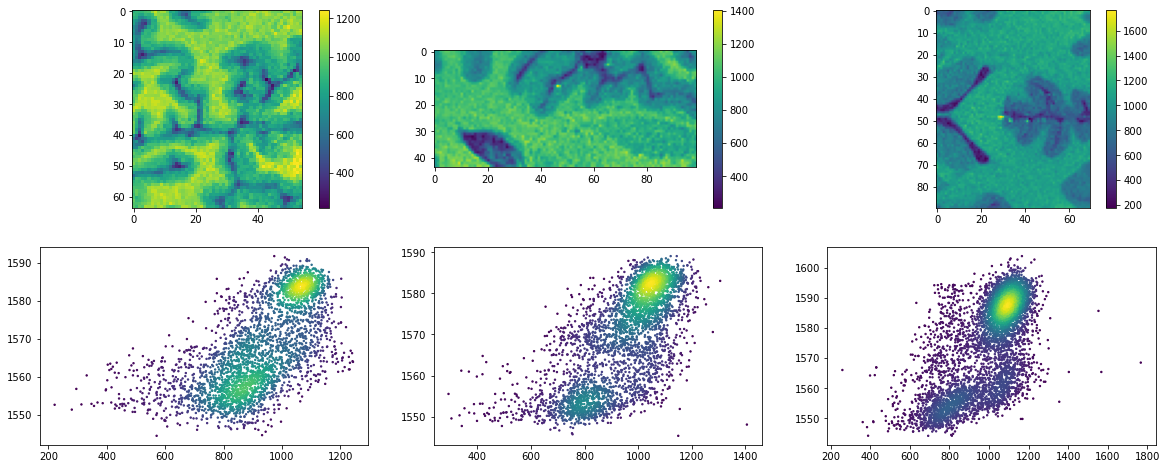

In [11]:
plot_filtered([sections[0],sections[3],sections[4]])
# plot_median([sections[0], sections[3], sections[4]])

# Perform Linear Regression

In [12]:
for i in range(len(sections)):
    sections[i].analyse()

Region 0 R2: -21.733711862811795
Region 1 R2: -15.358788641812524
Region 2 R2: -11.659217134066951


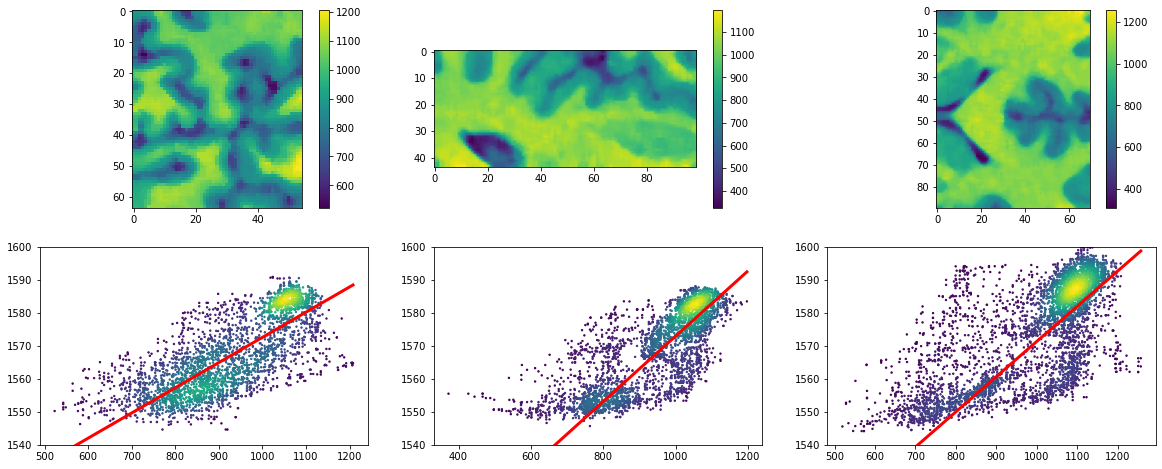

In [13]:
plot_analysed([sections[0],sections[3],sections[4]])


# NEXT FEW CELLS:
 1. Make a dataframe with the median-filtered MRI, SOS and (x,y) location for each pixel but with the horizontal lines
 2. if a point in this dataframr is NOT within a region around the best-fit
 line or is not in the filtered MRI, delete it 



In [14]:
def filter_df(df, T):
    f_df = df.copy()
    for x in range(df.shape[0]):
        if(not np.isnan(T[0])) and (np.isnan(T[1])): #only filtering downwards
            # print("filtering downwards")
            if(df['SOS'][x] < T[0]):
                f_df = f_df.drop(x)

        if( np.isnan(T[0]) ) and (not np.isnan(T[1])): #only filtering upwards
            # print("filtering upwards")
            if(df['SOS'][x] > T[1]):
                f_df = f_df.drop(x)
            # else: print(temp_s[x])
        
        if(not np.isnan(T[0])) and (not np.isnan(T[1])): #filtering in both directions
            # print("filtering both")
            if(df['SOS'][x] < T[0]):
                f_df = f_df.drop(x)
            if(df['SOS'][x] > T[1]):
                f_df = f_df.drop(x)
    return f_df

In [15]:
df = pd.DataFrame()
df['MRI'] = np.array(sections[4].m_m).flatten()
df['SOS'] = np.array(sections[4].m_s).flatten()
df['x'] = [j for i in range(90) for j in range(70)]
df['y'] = [i for i in range(90) for j in range(70)]

# filter this database so we dont worry about the horizontal lines
f_df = filter_df(df,Ts[4])
f_df['index'] = [x for x in range(f_df.shape[0])]
f_df

,MRI,SOS,x,y,index
0,635.341919,1551.175632,0,0,0
1,635.341919,1551.175632,1,0,1
2,643.891785,1552.456369,2,0,2
3,672.840393,1554.849426,3,0,3
4,650.339905,1555.586301,4,0,4
...,...,...,...,...,...
6295,883.370178,1556.926285,65,89,5660
6296,882.447571,1555.427411,66,89,5661
6297,878.724304,1554.019121,67,89,5662
6298,878.724304,1551.620972,68,89,5663


536

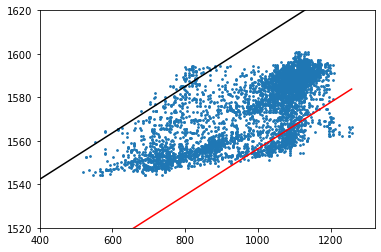

In [16]:
# using parametrs of the filtered data
oor = []

x = np.linspace(0,max(df['MRI']),num=10000)
y1 = sections[4].coef[0][0] * x + sections[4].inter[0] - 15
y2 = sections[4].coef[0][0] * x + sections[4].inter[0] + 35

plt.scatter(f_df['MRI'], f_df['SOS'], s=3) 
plt.plot(x, y1, 'r')
plt.plot(x ,y2, 'k')
plt.xlim(400,None)
plt.ylim(1520,1620)

for i in range(len(f_df['MRI'])):
    m = f_df.iloc[i]['MRI']
    s = f_df.iloc[i]['SOS']

    y1 = sections[4].coef[0][0] * m + sections[4].inter[0] - 15
    y2 = sections[4].coef[0][0] * m + sections[4].inter[0] + 35

    if (y1 > s) or ( s > y2):
        oor.append([f_df.iloc[i]['x'], f_df.iloc[i]['y']])

len(oor)

In [17]:
df_flag = df.copy()
for i in range(6300):
    if([df_flag['x'][i], df_flag['y'][i]] in oor):
        df_flag['MRI'][i] = 0
        df_flag['SOS'][i] = 0
len(df_flag[df_flag['MRI'] != 0])

/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_39253/3457352631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flag['MRI'][i] = 0
/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_39253/3457352631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flag['SOS'][i] = 0


5764

(1520.0, 1620.0)

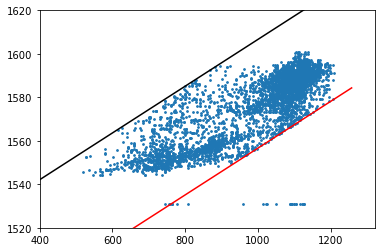

In [44]:
plt.scatter(df_flag['MRI'],df_flag['SOS'],s=3)
plt.plot(x, sections[4].coef[0][0] * x + sections[4].inter[0] - 15, 'r')
plt.plot(x ,sections[4].coef[0][0] * x + sections[4].inter[0] + 35, 'k')
plt.xlim(400,None)
plt.ylim(1520,1620)

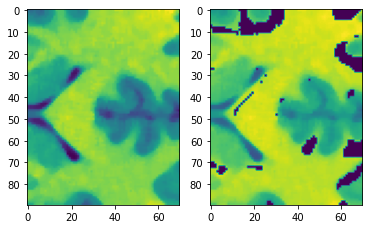

In [45]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(sections[4].m_m)
plt.subplot(1,2,2)
plt.imshow(np.array(df_flag['MRI']).reshape(90,70))

In [19]:
# doing the same for the 'good' one to compare the results:
dfg = pd.DataFrame()
dfg['MRI'] = np.array(sections[0].m_m).flatten()
dfg['SOS'] = np.array(sections[0].m_s).flatten()
dfg['x'] = [j for i in range(sections[0].m.shape[0]) for j in range(sections[0].m.shape[1])]
dfg['y'] = [i for i in range(sections[0].m.shape[0]) for j in range(sections[0].m.shape[1])]
f_dfg = filter_df(dfg,Ts[0])
f_dfg['index'] = [x for x in range(f_dfg.shape[0])]

# using parametrs of the filtered data
oor = []
for i in range(len(f_dfg['MRI'])):
    m = f_dfg.iloc[i]['MRI']
    s = f_dfg.iloc[i]['SOS']

    y1 = sections[0].coef[0][0] * m + sections[0].inter[0] - 15
    y2 = sections[0].coef[0][0] * m + sections[0].inter[0] + 35
    if (y1 > s) or ( s > y2):
        oor.append([f_dfg.iloc[i]['x'], f_dfg.iloc[i]['y']])
print(len(oor))
dfg_flag = dfg.copy()
for i in range(dfg['MRI'].shape[0]):
    if([dfg_flag['x'][i], dfg_flag['y'][i]] in oor):
        dfg_flag['MRI'][i] = 0
        dfg_flag['SOS'][i] = 0

91


/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_39253/1151410205.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg_flag['MRI'][i] = 0
/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_39253/1151410205.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg_flag['SOS'][i] = 0


In [20]:
dfg['MRI'].shape[0]

3520

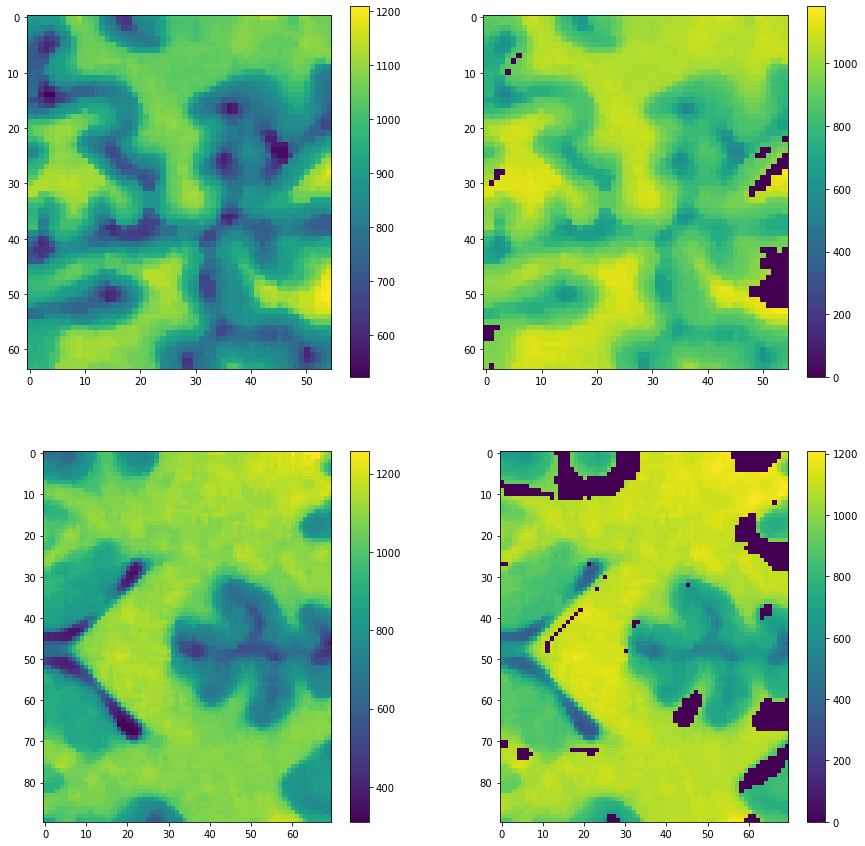

In [21]:
plt.subplots(2,2, figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(sections[0].m_m)
plt.colorbar()
# plt.title("Region 1 with outliers", fontsize=20)
# plt.xlabel("MRI values", fontsize=20)
# plt.ylabel("Sound speed values", fontsize=20)
plt.subplot(2,2,2)
# plt.title("Region 1 without outliers", fontsize=20)
# plt.xlabel("MRI values", fontsize=20)
# plt.ylabel("Sound speed values", fontsize=20)
plt.imshow(np.array(dfg_flag['MRI']).reshape(sections[0].m.shape))
# plt.imshow(sections[0].m_m)
plt.colorbar()
plt.subplot(2,2,3)
# plt.title("Region 3 with outliers", fontsize=20)
# plt.xlabel("MRI values", fontsize=20)
# plt.ylabel("Sound speed values", fontsize=20)
plt.imshow(sections[4].m_m)
plt.colorbar()
plt.subplot(2,2,4)
# plt.title("Region 3 without outliers", fontsize=20)
# plt.xlabel("MRI values", fontsize=20)
# plt.ylabel("Sound speed values", fontsize=20)
plt.imshow(np.array(df_flag['MRI']).reshape(90,70))
plt.colorbar()